In [4]:
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt

import fastmri
from fastmri.data import transforms as T
#from fastmri.data.mri_data import fetch_dir
#from fastmri.data.subsample import create_mask_for_mask_type
#from fastmri.data.transforms import UnetDataTransform
#from fastmri.pl_modules import FastMriDataModule, UnetModule



In [20]:
train_path = '/home/yusuf/Desktop/projects/data/fastmri/multicoil_train/'
val_path = '/home/yusuf/Desktop/projects/data/fastmri/multicoil_val/'
#file_list = os.listdir(train_path)
file_list = [f for f in os.listdir(train_path) if f.endswith('.h5')] #fancier
file_name = f'{train_path}/{file_list[4]}'
hf = h5py.File(file_name)

In [3]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT2', 'max': 0.0006489486017268892, 'norm': 0.13129568251285575, 'patient_id': '5c8bf4b5d9a1bddaffac9352be8cf2913078045bf6f03748608aa23801f90324'}


In [35]:
### no need to run each time || check for data shape compliance
dtchecklist = []
shchecklist = []
for i,file in enumerate(file_list):
    hf = h5py.File(f'{train_path}/{file}')
    volume_kspace = hf['kspace'][()]
    dtchecklist.append(volume_kspace.dtype)
    shchecklist.append(volume_kspace.shape)
#np.all([i==(16, 5, 640, 322) for i in shchecklist])

In [36]:
shchecklist

[(16, 5, 640, 322),
 (16, 20, 640, 320),
 (16, 16, 640, 320),
 (16, 4, 640, 320),
 (16, 14, 768, 396),
 (16, 4, 640, 320),
 (16, 20, 768, 396),
 (16, 16, 640, 320),
 (16, 12, 768, 396),
 (16, 12, 768, 396),
 (16, 4, 640, 320),
 (16, 16, 640, 320),
 (16, 14, 768, 396),
 (16, 20, 768, 396),
 (16, 4, 640, 320),
 (16, 20, 768, 396),
 (16, 20, 640, 320),
 (16, 16, 640, 320),
 (16, 16, 640, 320),
 (16, 4, 640, 320),
 (16, 16, 640, 320),
 (16, 16, 640, 320),
 (16, 20, 640, 320),
 (16, 10, 640, 320),
 (16, 4, 640, 322),
 (16, 16, 768, 396),
 (14, 20, 640, 320),
 (16, 20, 768, 396),
 (16, 16, 768, 396),
 (16, 4, 640, 320),
 (14, 4, 640, 320),
 (16, 20, 640, 320),
 (16, 20, 768, 396),
 (16, 12, 640, 320),
 (16, 16, 640, 320),
 (14, 6, 640, 320),
 (16, 6, 640, 320),
 (16, 20, 768, 396),
 (16, 14, 768, 396),
 (16, 20, 768, 396),
 (16, 14, 768, 396),
 (16, 16, 640, 320),
 (16, 4, 768, 392),
 (16, 20, 768, 396),
 (16, 12, 768, 396),
 (16, 12, 768, 396),
 (16, 4, 640, 322),
 (16, 16, 640, 320),
 (16,

In [13]:
volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[6] # Choosing the *6-th slice of this volume
volume_kspace.shape

(16, 20, 768, 396)

In [14]:
# function to plot specific coils
def show_coils(data, slice_nums, cmap="gray"):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [15]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

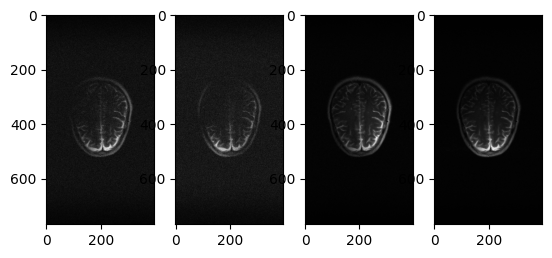

In [21]:
show_coils(slice_image_abs, [0,1,2,3])

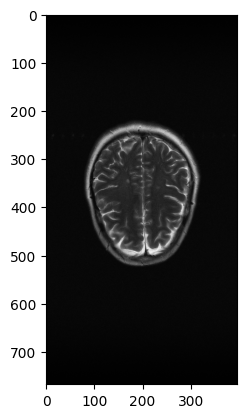

In [22]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
from fastmri.data.mri_data import SliceDataset
from fastmri.models import Unet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from fastmri.data.subsample import RandomMaskFunc


# choose mask func
# use seed for transform funcs


mask = create_mask_for_mask_type(mask_type_str="random",center_fractions=[0.08],accelerations=[4])
mask = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object
train_transform = UnetDataTransform(which_challenge="multicoil", mask_func=mask, use_seed=False)
val_transform = UnetDataTransform(which_challenge="multicoil", mask_func=mask)


In [41]:
train_dataset = SliceDataset(
    root=train_path,
    transform=train_transform,
    challenge="multicoil"
)
val_dataset = SliceDataset(
    root=val_path,
    transform=val_transform,
    challenge="multicoil"
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from fastmri.models import Unet

# Initialize the model
model = Unet(
    in_chans=1,           # Number of input channels
    out_chans=1,          # Number of output channels
    chans=32,             # Base number of channels in the UNet
    num_pool_layers=4,    # Number of pooling layers
    drop_prob=0.0         # Dropout probability
).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)


In [60]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets, _, _ in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets, _, _ in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)


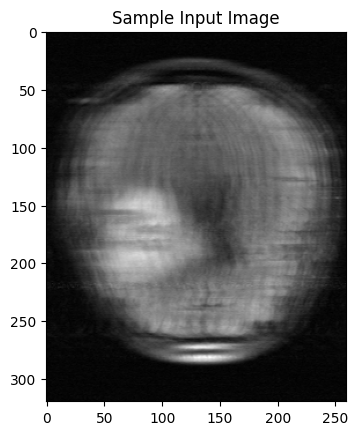

In [54]:
import matplotlib.pyplot as plt

for batch in train_loader:
    inputs= batch
    # Display the first image in the batch
    plt.imshow(inputs[0][0].cpu(), cmap="gray")  # .cpu() if using a GPU
    plt.title("Sample Input Image")
    plt.show()
    break


In [61]:
num_epochs = 3
best_val_loss = float("inf")

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Save model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet_model.pth")


ValueError: too many values to unpack (expected 4)

In [25]:
import h5py
from pathlib import Path

data_dir = Path('/home/yusuf/Desktop/projects/data/fastmri/multicoil_val/')

for file_path in data_dir.iterdir():
    try:
        with h5py.File(file_path, "r") as f:
            pass  # File opened successfully
    except OSError:
        print(f"Corrupted file: {file_path}")


Corrupted file: /home/yusuf/Desktop/projects/data/fastmri/multicoil_val/file_brain_AXT2_201_2010504.h5
